# Titanic Survival
**The Challenge** (from Kaggle)

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

## Import Modules

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import (train_test_split, StratifiedKFold)
from sklearn.impute import SimpleImputer
from sklearn import (preprocessing)
from sklearn.metrics import (auc, confusion_matrix, roc_auc_score, roc_curve)
#from yellowbrick.classifier import (ConfusionMatrix, ROCAUC)
#from yellowbrick.model_selection import (LearningCurve)

## Load the Dataset

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploratory Data Analysis
- The dataset contains 12 variable columns of information on 891 passengers.

In [4]:
df.shape

(891, 12)

In [5]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [6]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### About the Variables
#### Quantitative
**PassengerId:** passenger ID number<br>
**Pclass:** ticket class (1=1st, 2=2nd, 3=3rd)<br>
**Age:** passenger age<br>
**SibSp:** number of siblings/spouses aboard the Titanic<br>
**Parch:** number of parents/children aboard the Titanic<br>
**Fare:** passenger fare<br>

#### Qualitative
**Name:** name of the passenger<br>
**Sex:** sex of the passenger<br>
**Ticket:** ticket number<br>
**Cabin:** cabin number<br>
**Embarked:** port of embarkation<br>

#### Target
**Survived:** if the passenger survived or not (0=No, 1=Yes)

### Age
- The ages of the passengers on the Titanic range from less than 1 year old to 80 years old.

Text(0.5, 1.0, 'Survival by Age')

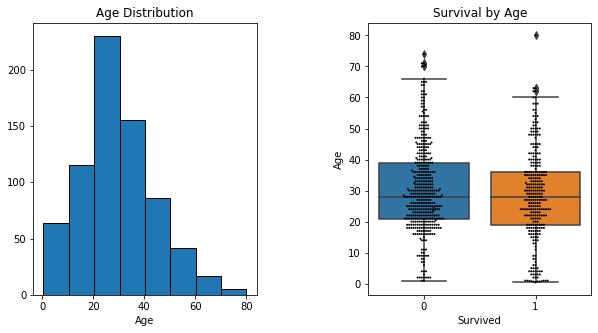

In [7]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1,2,1)
plt.hist(df.Age, ec="black", bins=8)
plt.xlabel("Age")
plt.title("Age Distribution")

plt.subplot(1,2,2)
sns.boxplot(data=df, x="Survived", y="Age")
sns.swarmplot(data=df, x="Survived", y="Age", color="black", size=2)
plt.title("Survival by Age")

In [8]:
print("Minimum Age:", df.Age.min())
print("Maximum Age:", df.Age.max())

Minimum Age: 0.42
Maximum Age: 80.0


### Pclass
- 55% of passengers were 3rd class, 24% were 1st class, and 21% were 2nd class.
- The majority of 3rd class passengers did not survive, about half of 2nd class passengers survived, and more than half 1st class passengers survived.

Text(0.5, 1.0, 'Survival by Class')

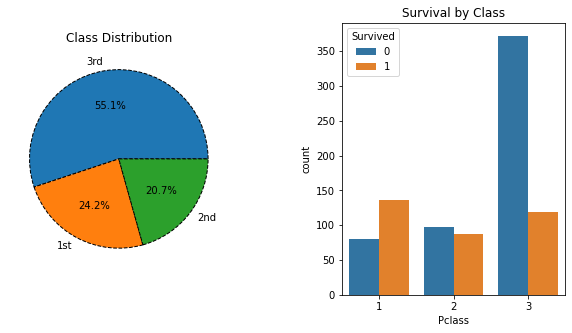

In [9]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1,2,1)
plt.pie(x=df.Pclass.value_counts(), labels=["3rd", "1st", "2nd"], autopct="%1.1f%%", 
        wedgeprops={"edgecolor":"0","linewidth": 1, "linestyle":"dashed"})
plt.title("Class Distribution")

plt.subplot(1,2,2)
sns.countplot(data=df, x="Pclass", hue="Survived")
plt.title("Survival by Class")

In [10]:
df.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

### SibSp and Parch

Text(0.5, 0, '# of Parents/Children on Board')

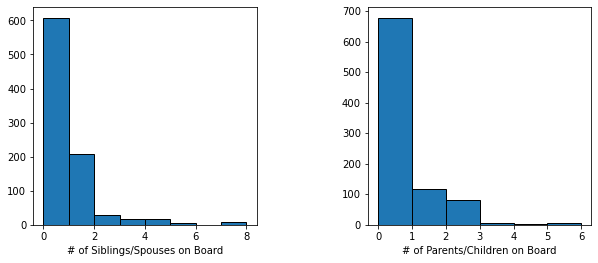

In [11]:
plt.figure(figsize=(10,4))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1,2,1)
plt.hist(df.SibSp, ec="black", bins=8)
plt.xlabel("# of Siblings/Spouses on Board")

plt.subplot(1,2,2)
plt.hist(df.Parch, ec="black", bins=6)
plt.xlabel("# of Parents/Children on Board")

### Fare
- The majority of passengers paid 50 dollars or less for their ticket.

Text(0.5, 1.0, 'Fare Distribution')

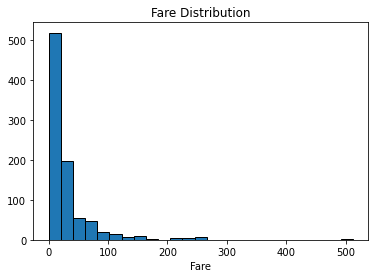

In [12]:
plt.hist(df.Fare, ec="black", bins=25)
plt.xlabel("Fare")
plt.title("Fare Distribution")

### Sex
- There were more male passengers than female passengers on board.
- More female passengers survived than male passengers.

Text(0.5, 1.0, 'Survival by Sex')

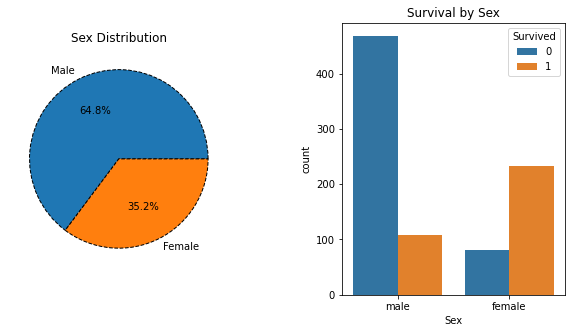

In [13]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1,2,1)
plt.pie(x=df.Sex.value_counts(), labels=["Male", "Female"], autopct="%1.1f%%", 
        wedgeprops={"edgecolor":"0","linewidth": 1, "linestyle":"dashed"})
plt.title("Sex Distribution")

plt.subplot(1,2,2)
sns.countplot(data=df, x="Sex", hue="Survived")
plt.title("Survival by Sex")

In [14]:
df.sort_values("Embarked", ascending=False).Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

## Preprocessing

### Split X and y Dataset

In [15]:
y = df.Survived
X = df.drop(columns="Survived")

### Missing Values
- The **age** column contains 177 missing values.
    - This will be reconciled by replacing missing values with the median age.
- The **cabin** column contains 687 missing values.
    - This will be reconciled by removing the column from the datset.
- The **embarked** column contains 2 missing values.
    - These missing values will be ignored.

In [16]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Dropping Columns
As mentioned above, the **cabin** column will be dropped due to a high number of missing values.

Additionally the following columns will be dropped, as they do not provide valuable information.<br>
- PassengerId<br>
- Ticket<br>
- Name<br>

### Create Binary Columns
Use the get_dummies function to create binary columns for the string variables **sex** and **embarked**. 

Since there are only two options for sex, male or female (non-male), it is already binary, and will simply be changed to 0/1 notation.

### Impute Age
As mentioned in the Missing values section, missing values in the **age** column will be replaced by the median.

### Standardize Data
The data will be standardized to ensure variables are on the same scale. 

### Clean-Up Function
The function below applies the above transformations.

In [17]:
def clean_up_titanic(X):
    
    #Drop non-value added columns
    X = X.drop(columns=["PassengerId", "Name", "Cabin", "Ticket"])
    
    #Get Dummies for Binary Columns
    X = pd.get_dummies(X)
    X = X.drop(columns="Sex_female")
    X_cols = np.array(X.columns)

    #Impute Age Column
    med = X.Age.median()
    X = X.fillna({"Age": med})
    
    #Standardize Data
    cols = ["Pclass", "Age", "SibSp", "Parch", "Fare"]
    scaler = preprocessing.StandardScaler()
    X[cols] = scaler.fit_transform(X[cols])

    #Turn back into DataFrame
    X = pd.DataFrame(X, columns=X_cols)
        
    return X

In [18]:
X = clean_up_titanic(X)

## Predictive Modeling

The following function fits and tests a model and scores it by the area under the receiving operating characterictics curve and the standard deviation using 5-Fold cross validation. The higher the AUC and lower the STD, the better the model performance.

In [19]:
from sklearn import model_selection

def model_fit_score(model, X, y):
    
    kfold = model_selection.KFold(n_splits=5)
    score = model_selection.cross_val_score(model, X, y, scoring="roc_auc", cv=kfold)
    print("AUC: "f"{score.mean():.3f} STD: {score.std():.2f}")

### Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42)
model_fit_score(lr, X, y)

AUC: 0.847 STD: 0.02


### Decision Tree

In [21]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=42)
model_fit_score(tree, X, y)

AUC: 0.764 STD: 0.03


### Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_fit_score(rf, X, y)

AUC: 0.856 STD: 0.04


### XGBoost Regressor

In [23]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=500, random_state=42)
model_fit_score(xgb, X, y)

AUC: 0.839 STD: 0.03


## Model Validation

The model with the highest AUC was the random forest model using 100 estimators. 

Let's see how the model performs when splitting the data into train and test.

#### Split Dataset

In [24]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

#### Fit and Score Model

In [25]:
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.8156424581005587

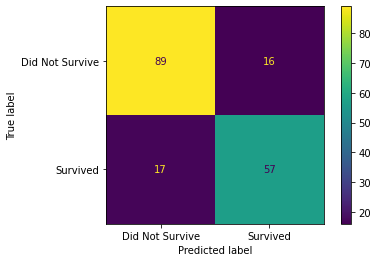

In [27]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(rf, X_test, y_test, display_labels=["Did Not Survive", "Survived"])  

## Conclusion
The random forest model was able to predict if a passenger would survive the Titanic disaster with an accuracy of almost 82%.